In [9]:
import numpy         as np
import pandas        as pd 
import os 
import math 
from   collections   import defaultdict
import matplotlib.pyplot as plt 
from george.kernels  import Matern32Kernel
from scipy           import optimize   as op
import george
from astropy.io     import ascii 
from joblib          import Parallel, delayed
import shutil
from multiprocessing import Pool
from scipy.optimize  import curve_fit


# Input


In [10]:
lc_path       = "/home/andrea/Desktop/Castor 2.0/Training_Set/data_lightcurves/"
sp_path       = "/home/andrea/Desktop/Castor 2.0/Training_Set/data_spectra/"
training_path = "/home/andrea/Desktop/Castor 2.0/Training_Set/"

training_set  = pd.read_excel(training_path + 'Training_Set.xlsx' )['Name'].tolist()

In [11]:
light_vel_A  = 3e+18 

In [12]:
bandpass               = {}
bandpass['filterlist'] = filterlist = ["UVW2", "UVM2", "UVW1", "u'", "u", "U", "B", "g", 
                                        "g'", "V", "r", "r'", "R", "i", "i'", "I", "z", "z'", 
                                        "Y", "J", "H", "Ks", "K"]
bandpass['centroid']   = centroid   = ([1928, 2246, 2600, 3500, 3546, 3571, 4344, 4767, 4825,
                                        5456, 6156, 6261, 6442, 7472, 7672, 7994, 8917, 9097,
                                        10380, 12500, 16300, 21450, 21900])                  
bandpass['fwhm']       = fwhm       = ([657, 498, 693, 80, 457, 524, 797, 928, 1379, 
                                        807, 813, 1382, 1377, 891, 1535, 1079, 1183, 1370, 
                                        2130, 3110, 4020, 3770, 3930])

In [13]:
def sampling_step(x):
    dx = np.diff(np.sort(x))
    return dx[dx != 0]

def nll(p, y, gp, computed):
  gp.set_parameter_vector(p)
  ll = gp.log_likelihood(y, quiet=True)
  return -ll if np.isfinite(ll) else 1e25

def grad_nll(p, y, gp, computed):
  gp.set_parameter_vector(p)
  return -gp.grad_log_likelihood(y, quiet=True)

In [14]:
def collect_lightcurves(name, path):
    lc_path   = path +  name + ".dat"
    lc_set    = defaultdict(list)
    band_dict = defaultdict(list)

    with open(lc_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            time  = float(parts[0])
            mag   = float(parts[1])
            emag  = float(parts[2])
            band  = parts[3]

            band_dict[band].append((time, mag, emag))

    for band, values in band_dict.items():
        lc_set[f'time_{band}'], lc_set[f'mag_{band}'], lc_set[f'emag_{band}'] = zip(*values)

    lc_filters         = list(band_dict.keys())
    ordered_lc_filters = [band for band in filterlist if band in lc_filters]

    return ordered_lc_filters, lc_set

def time_of_explosion(lc_set, lc_filters):
    t0, t1, dt = [], [], []

    for filtro in lc_filters:
        time = np.array(lc_set['time_' + filtro])
        t1.append(time[0])
        dt.append(abs(np.mean(np.diff(time[:10]))))

    t0        = np.array(t1) - np.array(dt)
    min_value = np.min(t0)

    return min_value


def rescale_time(lc_filters, lc_set, t0):
    new_set = {}

    for filtro in lc_filters:
        time = np.array(lc_set['time_' + filtro])
        mag  = np.array(lc_set['mag_' + filtro])
        emag = np.array(lc_set['emag_' + filtro])

        scale_time = time - t0

        sorted_indices = np.argsort(scale_time)
        scale_time     = scale_time[sorted_indices]
        mag            = mag[sorted_indices]
        emag           = emag[sorted_indices]

        new_set['time_%s' % filtro] = scale_time
        new_set['mag_%s' % filtro] = mag
        new_set['emag_%s' % filtro] = emag

    return new_set



def process_filter(filtro, ref_new_set, ref_time):

    x         = np.array(ref_new_set['time_' + filtro])
    y         = np.array(ref_new_set['mag_' + filtro])
    yerr      = np.array(ref_new_set['emag_' + filtro])
    amplitude = np.mean(y)

    lengthscale0 = np.mean(x)
    lengthscale1 = np.min(sampling_step(x))
    lengthscale2 = np.max(sampling_step(x))


    k0           = amplitude * Matern32Kernel(lengthscale0)
    k1           = amplitude * Matern32Kernel(lengthscale1)
    k2           = amplitude * Matern32Kernel(lengthscale2)
    kernel       = k1 + k2 + k0 

    gp           = george.GP(kernel)
    star         = gp.compute(x, yerr)

    p0           = gp.get_parameter_vector()
    results      = op.minimize(nll, p0, args = (y, gp, star), jac=grad_nll, method="L-BFGS-B")
    gp.set_parameter_vector(results.x)

    mu, cov = gp.predict(y, ref_time)
    std     = np.sqrt(np.diag(cov))

    return {'time_' + filtro: ref_time, 'mag_' + filtro: mu, 'emag_' + filtro: std}

def gaussian_process(common_filters, new_set, files):
    gp_set = defaultdict(list)

    results = Parallel(n_jobs=-2)(delayed(process_filter)(filtro, new_set, new_set['time_'+filtro]) for filtro in common_filters)

    for result in results:
        gp_set.update(result)

    return gp_set

In [15]:
def read_single_file(file_path):

    file_name = os.path.basename(file_path)
    epoch     = float(file_name.split('_')[1].rsplit('.', 1)[0]) 
    epoch     = epoch - t0 
    data      = ascii.read(file_path)

    return epoch, data

def collect_spectra(name, sp_path, t0):

    sp_set       = defaultdict(list)
    spectra_path = os.path.join(sp_path, name)
    all_files    = os.listdir(spectra_path)
    valid_files  = [os.path.join(spectra_path, file) for file in all_files if not (file.startswith('.') or file.lower() == 'desktop.ini')]
    all_epochs   = set()

    with Pool() as pool:
        results = pool.map(read_single_file, valid_files)

    for epoch, data in results:

        all_epochs.add(epoch)
        sp_set[f'wave_{epoch}']  = data[0][:]
        sp_set[f'flux_{epoch}']  = data[1][:]

    return sorted(all_epochs), sp_set

def wavelength_coverage(ref_files, ref_sp_set): 

    min_wave = [] 
    max_wave = [] 

    for epoch in ref_files: 
        wave = np.array(ref_sp_set['wave_' + str(epoch)]) 
        min_wave.append(np.min(wave)) 
        max_wave.append(np.max(wave)) 
    
    return ([int(np.mean(min_wave)), int(np.mean(max_wave))])

def filters_coverage(wave_range): 

    spectral_filters = []
    for i in range(len(centroid)): 
        min_wave = centroid[i] - fwhm[i] / 2
        max_wave = centroid[i] + fwhm[i] / 2
        if wave_range[0] <= min_wave and wave_range[1] >= max_wave: 
            spectral_filters.append(filterlist[i])

    return spectral_filters



In [16]:
def matched_bands(lc_filters, spectral_filters):

    tot_filters = set(lc_filters).intersection(spectral_filters)

    return tot_filters

In [17]:
def calibration(files, sp_set, t0, gp_set, tot_filters): 

    sp_points = np.array([]) 
    lc_points = np.array([])
    er_points = np.array([])
    time_list = [0] 
  
    for epoch in files: 
        
        wave = np.array(sp_set['wave_' + str(epoch)])
        flux = np.array(sp_set['flux_' + str(epoch)]) * wave**2/ light_vel_A
        poly_fit = np.polyfit(wave, flux, 2 )
        continuum   = np.polyval(poly_fit, wave)
        mean_value  = np.mean(continuum) 

        for filtro in tot_filters: 
            time = gp_set['time_' + filtro]
            mag  = gp_set['mag_' + filtro] 
            emag = gp_set['emag_' + filtro]
            closest  = min(time, key = lambda x: abs(x-epoch-t0))
            index_lc = time.index(closest)     
            mag_lc   = mag[index_lc]
            emag_lc  = emag[index_lc]   

            if abs(closest-epoch-t0) < 2 :#and closest not in time_list: 
            

                mag_sp   = -2.5 * np.log10(mean_value) - 48.6 
                sp_points = np.append(sp_points, mag_sp) 
                lc_points = np.append(lc_points, mag_lc) 
                er_points = np.append(er_points, emag_lc + 0.1*mag_sp) 
                time_list.append(closest) 
            
       
    return sp_points, lc_points, er_points

## Execute

In [21]:
total_sp = np.array([])
total_lc = np.array([])
total_er = np.array([])

for name in training_set: 
    print('Working on ', name) 
    lc_filters, lc_set     = collect_lightcurves(name, lc_path)
    t0                     = time_of_explosion(lc_set, lc_filters)
    files, sp_set          = collect_spectra(name, sp_path, t0)
    gp_set                 = gaussian_process(lc_filters, lc_set, files)
    wave_range             = wavelength_coverage(files, sp_set)
    spectral_filters       = filters_coverage(wave_range)
    tot_filters            = matched_bands(lc_filters, spectral_filters)
    sp, lc, er             = calibration(files, sp_set, t0, gp_set, tot_filters) 

    total_sp = np.append(total_sp, sp) 
    total_lc = np.append(total_lc, lc)  
    total_er = np.append(total_er, er) 

print('-----------------------------') 
print('We have a total of ', len(total_sp), 'points')
print('-----------------------------') 
print('Finished!')

Working on  iPTF13bvn
Working on  PTF10qts
Working on  ASASSN14jb
Working on  ASASSN15ed
Working on  ASASSN15oz
Working on  SN1987A
Working on  SN1993J
Working on  SN1994I
Working on  SN1998bw
Working on  SN1999dn
Working on  SN1999em
Working on  SN2002ap
Working on  SN2004aw
Working on  SN2004et
Working on  SN2004fe
Working on  SN2004gq
Working on  SN2004gt
Working on  SN2004gv
Working on  SN2005bf
Working on  SN2005cs
Working on  SN2005hg
Working on  SN2005ip
Working on  SN2005kj
Working on  SN2006aa
Working on  SN2006aj
Working on  SN2006ep
Working on  SN2006jd
Working on  SN2006qq
Working on  SN2006T
Working on  SN2007gr
Working on  SN2007od
Working on  SN2007pk
Working on  SN2007ru
Working on  SN2007uy
Working on  SN2007Y
Working on  SN2008aq
Working on  SN2008ax
Working on  SN2008bj
Working on  SN2008bo
Working on  SN2008D
Working on  SN2008fq
Working on  SN2008in
Working on  SN2009bb
Working on  SN2009bw
Working on  SN2009dd
Working on  SN2009ib
Working on  SN2009ip
Working on  

In [20]:
def linear_fun(x, m, q):
    return m*x + q

par, cov = curve_fit(linear_fun, total_sp, total_lc, sigma=total_er)
m = par[0]
q = par[1]
variances = np.diag(cov)
errors    = np.sqrt(variances)
err_m = errors[0] 
err_q = errors[1] 
x_axis = np.linspace(np.min(total_sp), np.max(total_sp), 5000)
linear_fit = x_axis * m + q 
linear_fit_sigma = x_axis * err_m + err_q 

print('m =', round(m, 4), '+/-', round(err_m,4))
print('q =', round(q, 4), '+/-', round(err_q,4))

m = 0.9189 +/- 0.0026
q = 1.2218 +/- 0.0376


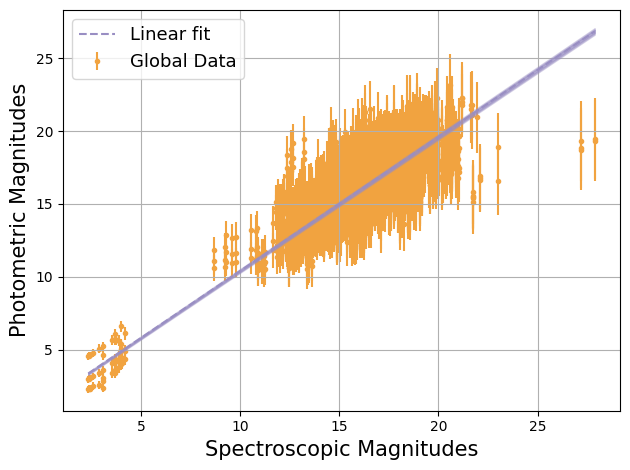

In [22]:
plt.figure()
plt.errorbar(total_sp, total_lc, total_er, fmt='.', label='Global Data', color='#f1a340', zorder=1) 
plt.plot(x_axis, linear_fit, '--',  label='Linear fit', color='#998ec3', zorder=2)
plt.fill_between(x_axis, linear_fit + linear_fit_sigma, linear_fit - linear_fit_sigma, alpha=0.6 ,color='#998ec3', zorder=2)
plt.fill_between(x_axis, linear_fit + 2*linear_fit_sigma, linear_fit - 2*linear_fit_sigma, alpha=0.4 ,color='#998ec3', zorder=2)

plt.grid()
plt.xlabel('Spectroscopic Magnitudes',  fontsize = 15)
plt.ylabel('Photometric Magnitudes', fontsize = 15)

#plt.gca().invert_yaxis()
plt.legend(ncol=1, fontsize = 13)
plt.tight_layout()
pass